# Example documenting Synergia Bunch Creation

This notebook shows how to create, import, and export bunches in Synergia. The intention is to document some simple bunch creation methods which permit some flexibility within the Sirepo interface. First, we will document how bunches are generated, dumped to file, and imported. Next, we will demonstrate the use of scripts for creating the following bunch types:

1. Matched Gaussian bunch creation
2. Arbitrary Gaussian bunch creation (user-specified TWISS parameters)
3. Matched "Generalized K-V" distribution for running with the nonlinear element


Most of Synergia's built-in functions can be found in the [optics/bunch_matching.py](https://cdcvs.fnal.gov/redmine/projects/synergia2/repository/revisions/devel/entry/src/synergia/optics/matching.py) file of the source code.

As needed, these bunch creation scripts will be incorporated into rssynergia or rsbeams.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
from rssynergia.base_diagnostics import read_bunch
from rssynergia.base_diagnostics import write_bunch
from rssynergia.base_diagnostics import workflow
from rssynergia.base_diagnostics import lfplot
from rssynergia.base_diagnostics import latticework
from rssynergia.base_diagnostics import basic_calcs
from rssynergia.base_diagnostics import pltbunch
from rssynergia.base_diagnostics import elliptic_sp
from rssynergia.base_diagnostics import singleparticle
from rssynergia.base_diagnostics import options
from rssynergia.base_diagnostics import diagplot
from rssynergia.standard import standard_beam6d
from rssynergia.elliptic import elliptic_beam6d
from rssynergia.semigaussian import semi_gaussian6d

from rsbeams.rsptcls import bunch

import synergia
import synergia_workflow

In [3]:
comm = synergia.utils.Commxx()

# Lattices
### Import an external file for matching

We import a linear version of the IOTA lattice for matching a standard Gaussian, as well as the version with 1 nonlinear insert.

In [4]:
#================== Load the lattice =======================
#Assumes radiasoft/ioptics and radiasoft/rssynergia share a common directory
lattices = {}
lattice_repo = '/home/vagrant/jupyter/ioptics/ioptics/lattices/Iota6-6/'

lattices['t1_1IO_66'] = lattice_repo + "lattice_1IO_center.madx" #centered t1 6.6 1IO lattice
lattices['t3_1IO_66'] = lattice_repo + "lattice_1IO_nll_center.madx" #centered t3 6.6 1IO lattice

name = 't3_1IO_66'

lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices[name])

for elem in lattice.get_elements():
    if elem.get_type() == 'nllens':
        elem.set_string_attribute("extractor_type", "chef_propagate")
    else:
        elem.set_string_attribute("extractor_type", "chef_map") 
        
nsteps_per_element = 5
nsteps = len(lattice.get_elements())*nsteps_per_element
        
order = 1
outputdir = 'example_run'

opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
opts.macro_particles=10000
#opts.emitx = 1.0e-5
workflow.make_path(outputdir)

stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

#construct bare lattice for comparison
bare_lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices['t1_1IO_66'])
bare_stepper = synergia.simulation.Independent_stepper_elements(bare_lattice, opts.map_order, opts.steps_per_element)
bare_lattice_simulator = bare_stepper.get_lattice_simulator()

# Bunch Creation

First we must specify the fixed parameters for the bunch, which will remain constant for each creation technique. These include the reference particle energy and the bunch emittance.

In [5]:
#define the reference particle to obtain relativistic beta, gamma values
#these are needed to define the longitudinal coordinates of the bunch
ref = lattice.get_reference_particle()
beta = ref.get_beta()
gamma = ref.get_gamma()

#We want the normalized emittance in x to be 0.3 mm-mrad
opts.norm_emittance = 0.3*1.e-6
opts.emitx = basic_calcs.calc_geometric_emittance(opts.norm_emittance, beta, gamma)
opts.emity = opts.emitx

### Matched Gaussian

Here Synergia's capabilities are used to generate an uncoupled, matched Gaussian. The function is `synergia.optics.generate_matched_bunch_transverse()`, and requires the following arguments:
    - lattice_simulator:         A Synergia lattice simulator
    - emittance_x (float):       The x emittance in m-rad
    - emittance_y (float):       The y emittance in m-rad
    - $\sigma_z$ (float):        The standard deviation of the z-coordinate of particles in the bunch in m
    - $\delta_p/p$ (float):      The standard deviation of the momentum coordinate ($\delta_p/p)
    - real_particles (float):    The number of real particles in the bunch (corresponding to the toal bunch charge)
    - macro_particles (float):   The number of macro particles being used to represent the bunch
    - seed (int):                The seed for the random number generator used to build the bunch

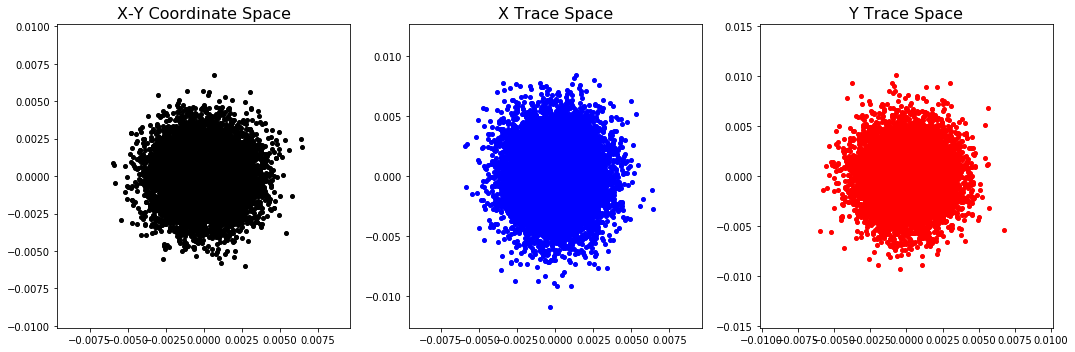

/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


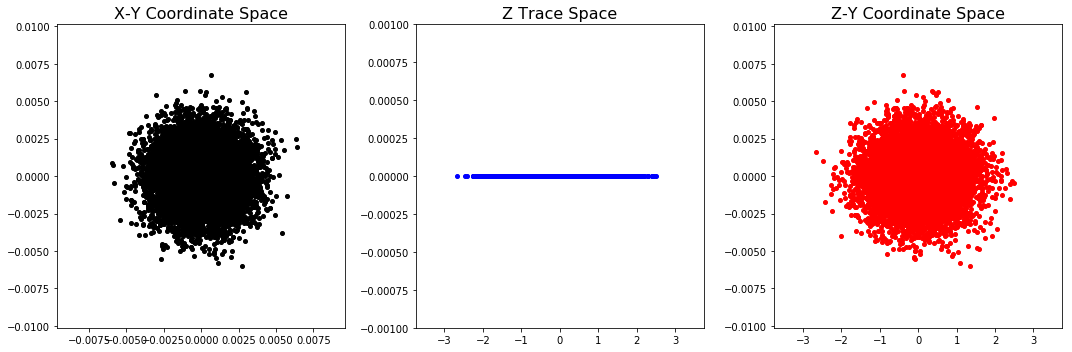

In [6]:
#Construct a matched Gaussian bunch
myBunch = synergia.optics.generate_matched_bunch_transverse(
    bare_lattice_simulator, opts.emitx, opts.emity, opts.stdz, 
    opts.dpop, opts.real_particles, 
    opts.macro_particles, opts.seed) 

#plot the bunch
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

#### Saving and Loading your Bunch

To save the bunch, I use numpy to export the particle coordinates to a text file, and then use the `read_bunch` module (located in [rssynergia/base_diagnostics/read_bunch](https://github.com/radiasoft/rssynergia/blob/master/rssynergia/base_diagnostics/read_bunch.py)) to read in the text file and reconstruct the bunch. 

All files should consist of Nx7 arrays, with N being the number of particles, and contain the 6-dimensional phase space of the particles with the order: x, x', y, y', cdt, $\delta$p/p$_0$, pID according to Synergia's [unit conventions](http://compacc.fnal.gov/~amundson/html/units.html#kinematics).

The `read_bunch` function can read in files with the following formats:
- .txt - standard text file
- .mxtxt - text file with coordinates given by MAD-X kinematic conventions
- .h5 - standard hdf5 file

The `read_bunch` function needs the following arguments:
    - particles_file (string): the file containing the particles coordinates
    - refpart (synergia.foundation.foundation.Reference_particle): a Synergia reference particle for the bunch
    - num_real_particles (float): the number of real particles
    - bucket_length (float): the longitudinal length of the bucket
    - comm (synergia.utils.parallel_utils.Commxx): the Commxx communicator object for this bunch
    - verbose (Optional[Boolean]): Flag for verbose feedback

To complement the `read_bunch` features, I've created a corresponding `write_bunch` script (located in [rssynergia/base_diagnostics/write_bunch](https://github.com/radiasoft/rssynergia/blob/master/rssynergia/base_diagnostics/write_bunch.py)).

The `write_bunch` function needs the following arguments:
    - bunch (synergia.bunch.bunch.Bunch): A Synergia bunch object to be written to file
    - fn (Optional[String]): File name for saving the bunch - defaults to 'particles.h5'
    - txt (Optional[Bool]): Whether to write to a .txt file - defaults to False (e.g. write to HDF-5)

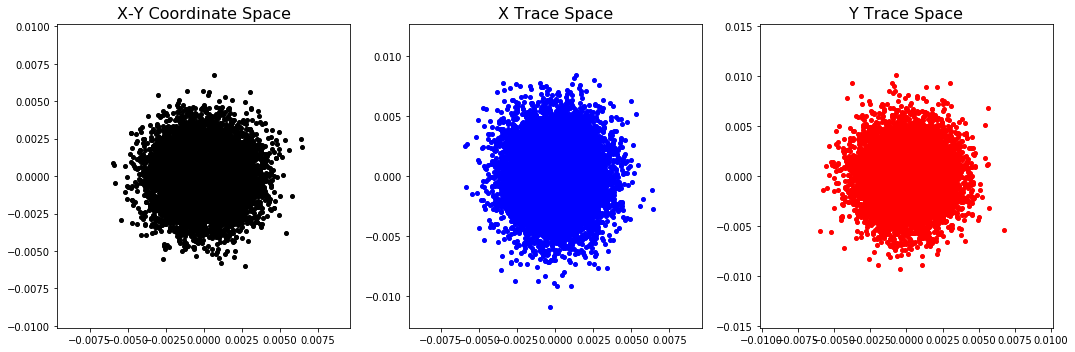

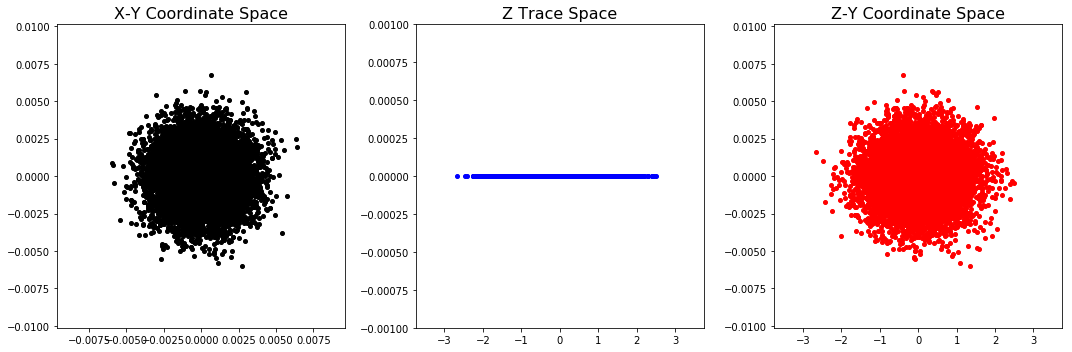

In [7]:
#Write the bunch to file
write_bunch.write_bunch(myBunch, reference_particle=ref)

#Now read it in and plot it to compare

#The user can specify the bucket_length, but if there is none, a default value will be provided.
#This is necessary when making use of RF features in Synergia, but isn't needed for a coasting beam

l_bucket = beta*lattice.get_length()/4 #RF harmonic number is 4

myBunch_bucket = read_bunch.read_bunch('particles.h5', ref, opts.real_particles, comm, bucket_length=l_bucket)
pltbunch.plot_bunch(myBunch_bucket)
pltbunch.plot_long(myBunch_bucket)

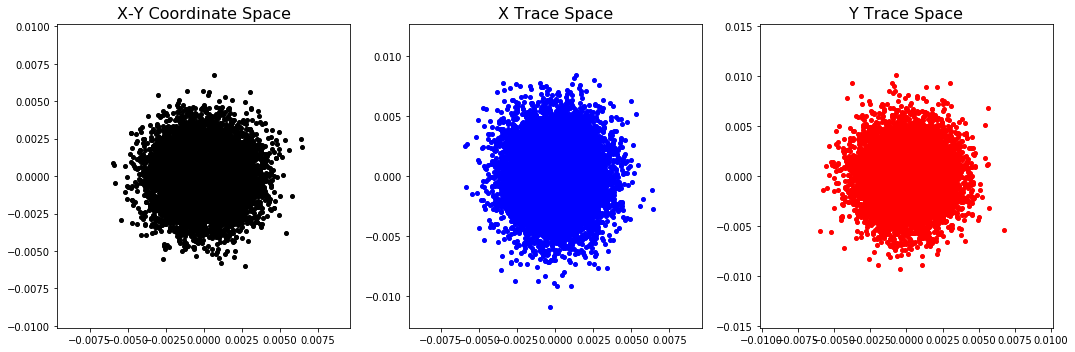

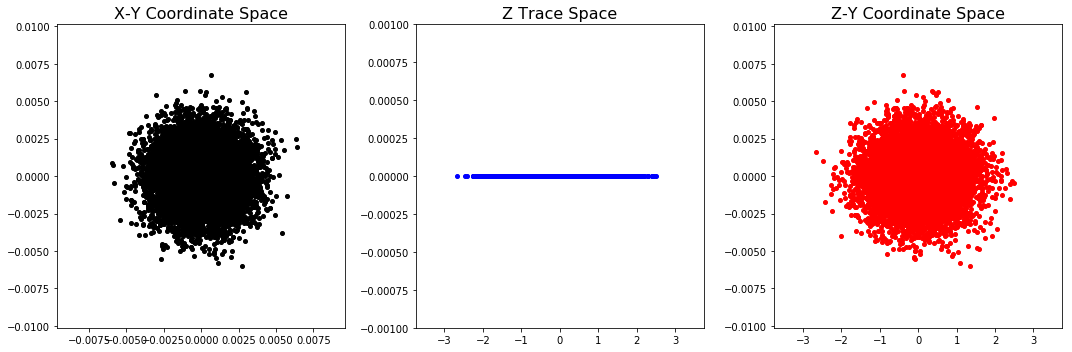

In [8]:
#Demonstrate without bucket_length input
myBunch_nobucket = read_bunch.read_bunch('particles.h5', ref, opts.real_particles, comm)
pltbunch.plot_bunch(myBunch_nobucket)
pltbunch.plot_long(myBunch_nobucket)

### Other Distributions - The rsbeams `StandardBunch()` class

I've developed a bunch class in the [rsbeams/rsptcls/bunch.py](https://github.com/radiasoft/rsbeams/blob/master/rsbeams/rsptcls/bunch.py) module, which can be used to describe different types of distributions, for example K-V distributions (see [here](http://inspirehep.net/record/919865/files/HEACC59_297-311.pdf) for original reference), or mismatched Gaussians where the Twiss parameters ($\beta$ and $\alpha$) can be arbitrarily adjusted.

Instantiation of the `StandardBunch()` class requires the following arguments:

    - npart (int): the number of particles in the bunch
    - dist (string): the distribution type being used, defaults to Gaussian
    - emitx (float): RMS uncorrelated emittance in the x-px plane, defaults to 1 mm-mrad
    - emity (float): RMS uncorrelated emittance in the y-py plane, defaults to 1 mm-mrad
    - betax (float): the beta function where the bunch is being matched, defaults to 1
    - alphax (float): one-half the derivative of the beta function, defaults to 0
    - betay (float): the beta function where the bunch is being matched, defaults to 1
    - alphay (float): one-half the derivative of the beta function, defaults to 0
    - stdz (float): standard deviation in z-coordinate, defautls to 0
    - dpop (float): standard deviation in delta-p/p0 coordinate, defaults to 0
    - seed (float): seed for psuedorandom generator. Defaults to None, and is generate during initialization.

The particle data is stored by the `particles` attribute, and is what is required to define the bunch for Synergia.


The class assumes that the distribution is only matched to the 4D phase space, hence the setting of longitudinal coordinates (`set_longitudinal_coordinates`) is separated from that of transverse coordinates (`set_transverse_coordinates`). Each of these functions permits re-setting of Twiss parameters (beta/alpha). These affect the distribution of particles, but not the overarching properties, such as number of particles, distribution shape, or emittance. The procedure for generating a bunch with a complete phase space coordinates is as follows:

    myBunch = bunch.StandardBunch(npart, emitx = 1.0e-6, betax = bx, betay= by, ...)
    myBunch.set_longitudinal_coordinates( dpop = newdpopvalue )
    myBunch.set_transverse_coordinates(betax = newbetaxvalue)

Currently, one may only specify a `KV` or `Gaussian` distribution. In the near future, I will develop a derived class which permits matching to the elliptic nonlinear insert used in IOTA and other integrable systems.

#### Example: Gaussian

In [9]:
npart = 10000
newBunch = bunch.StandardBunch(npart)
newBunch.set_longitudinal_coordinates()
newBunch.set_transverse_coordinates(betax = 2.0) #here we set betax to be larger as an example
newBunch.print_Twiss()

Twiss parameters in use:
betax : 2.0
betay : 1.0
alphax : 0.0
alphay : 0.0
gammax : 0.5
gammay : 1.0


In [10]:
reBunch = read_bunch.read_bunch(newBunch.particles, ref, opts.real_particles, comm, l_bucket)

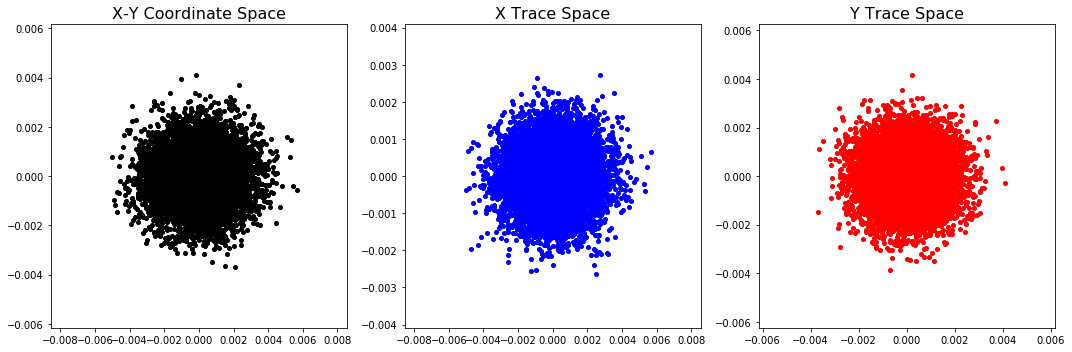

/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=-0.0
  'bottom=%s, top=%s') % (bottom, top))


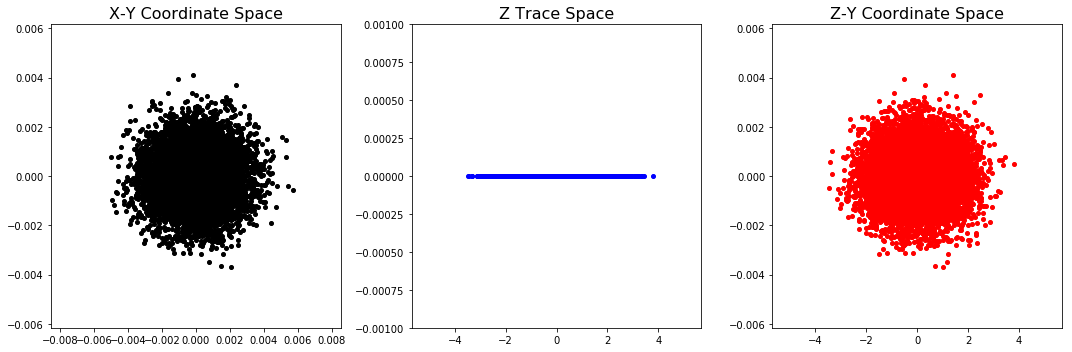

In [11]:
pltbunch.plot_bunch(reBunch)
pltbunch.plot_long(reBunch)

#### Example: K-V distribution

In [12]:
npart = 10000
newKVBunch = bunch.StandardBunch(npart, dist='KV')
newKVBunch.set_longitudinal_coordinates(dpop=0.01) #here we reset the dpop value
newKVBunch.set_transverse_coordinates()
newKVBunch.print_Twiss()

Twiss parameters in use:
betax : 1.0
betay : 1.0
alphax : 0.0
alphay : 0.0
gammax : 1.0
gammay : 1.0


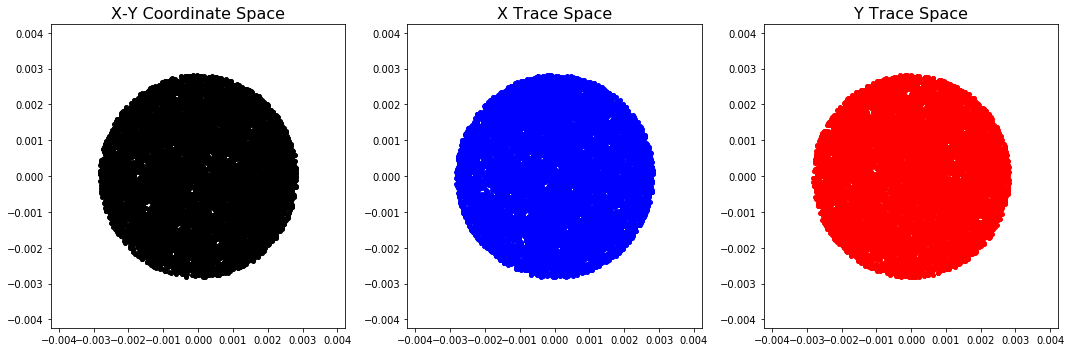

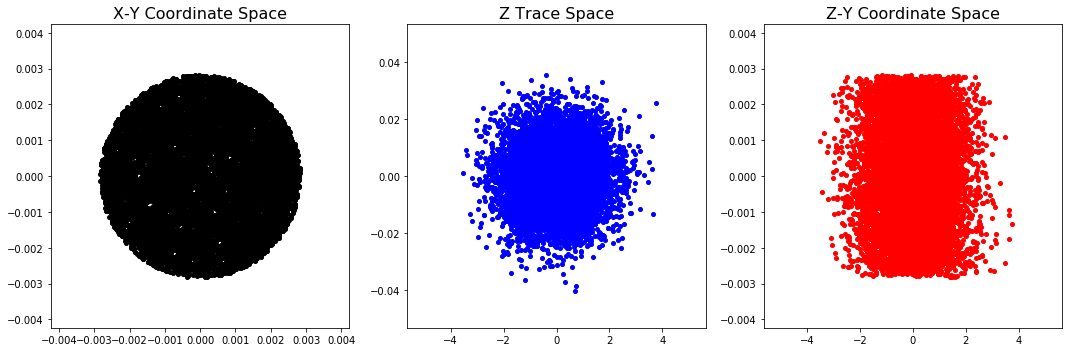

In [13]:
reKVBunch = read_bunch.read_bunch(newKVBunch.particles, ref, opts.real_particles, comm, l_bucket)
pltbunch.plot_bunch(reKVBunch)
pltbunch.plot_long(reKVBunch)

#### Plans to support the nonlinear element: Updated 6/25/2018

A derived class `NonlinearBunch` has been developed. This class creates distributions matched to a given nonlinear insert, with additional inputs to specify the nonlinear insert strength and aperture parameters.

        - npart (int): the number of particles in the bunch
        - dist (string): distribution type ['KV, 'waterbag', 'Gaussian'], defaults to KV
        - emitx (float): RMS uncorrelated emittance in the x-px plane, defaults to 1 mm-mrad
        - emity (float): RMS uncorrelated emittance in the y-py plane, defaults to 1 mm-mrad
        - betax (float): the beta function where the bunch is being matched, defaults to 1
        - alphax (float): one-half the derivative of the beta function, defaults to 0
        - betay (float): the beta function where the bunch is being matched, defaults to 1
        - alphay (float): one-half the derivative of the beta function, defaults to 0
        - stdz (float): standard deviation in z-coordinate, defautls to 0
        - dpop (float): standard deviation in delta-p/p0 coordinate, defaults to 0
        - seed (float): seed for psuedorandom generator. Defaults to None, and is generate during initialization.
        - quiet (Boolean): boolean describing whether to use exact centroid injection, defaults to false.
        - t (float): nonlinear strength parameter for the insert. Defaults to 0.1 (unitless).
        - c (float): the nonlinear aperture parameter (m^-1/2), defining poles in the x-axis. Defaults to 0.01.
        - cutoff (float): cutoff parameter for the nonlinear Gaussian distributoin, defaults to 4.
        
        
The class currently supports 3 different bunch distributions:
    1. Generalized K-V: Particles populate a single level set of H, and are distributed uniformly in configuration space to achieve the desired 4D emittance.
    2. Waterbag: Particles are distributed uniformly within a 4D ellipsoid and within a range of H values out to a maximum. For a linear system, the Waterbag uniformly populates H values out to the maximum, but for the nonlinear distribution, the distribution is linear in H out to the maximum.
    3. Gaussian: Particles are distributed among level sets of H space along an exponential $\exp{-H/\eps_0}$ out to a cutoff value $H/\eps_0 < C$.
    
As with the `StandardBunch()` class, specification of the longitudinal and transverse coordinates is done separately.

#### Example: Nonlinear Generalized K-V distribution

In [14]:
npart = 10000
c0 = 0.01
t0 = 0.4

myNLBunch = bunch.NonlinearBunch(npart, emitx=20e-6, emity=20e-6, t=t0, c=c0)
myNLBunch.set_longitudinal_coordinates()
myNLBunch.set_transverse_coordinates()
myNLBunch.print_Twiss()

Twiss parameters in use:
betax : 1.0
betay : 1.0
alphax : 0.0
alphay : 0.0
gammax : 1.0
gammay : 1.0


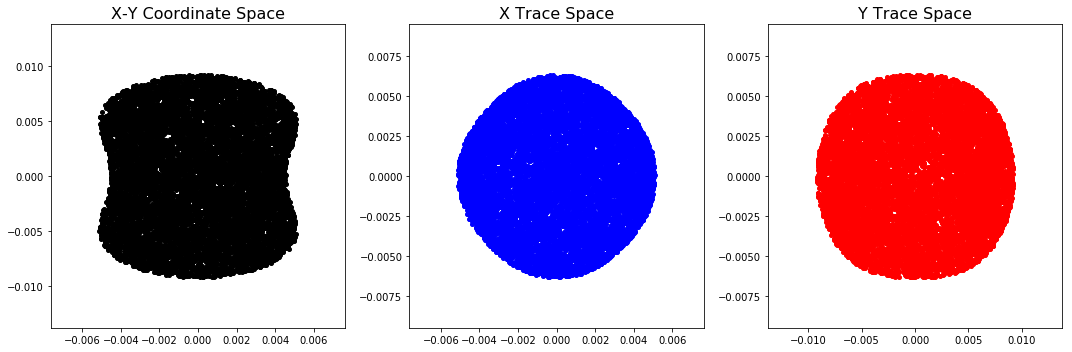

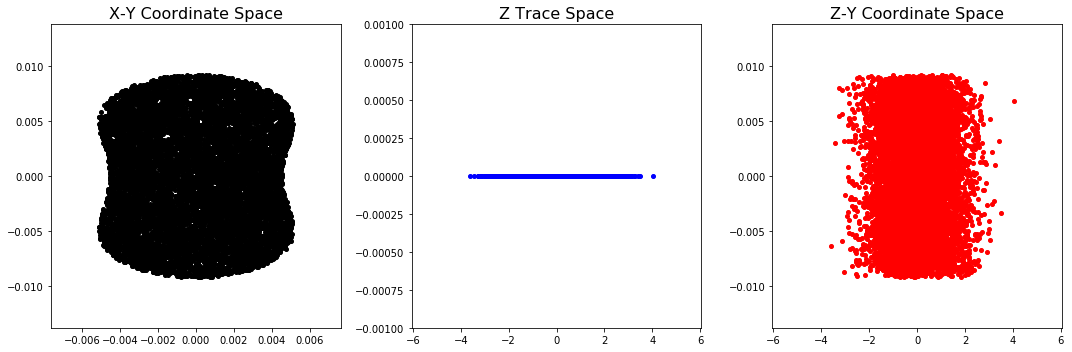

In [15]:
nlKVBunch = read_bunch.read_bunch(myNLBunch.particles, ref, opts.real_particles, comm, l_bucket)
pltbunch.plot_bunch(nlKVBunch)
pltbunch.plot_long(nlKVBunch)

#### Example: Nonlinear Waterbag Distribution

Twiss parameters in use:
betax : 1.0
betay : 1.0
alphax : 0.0
alphay : 0.0
gammax : 1.0
gammay : 1.0


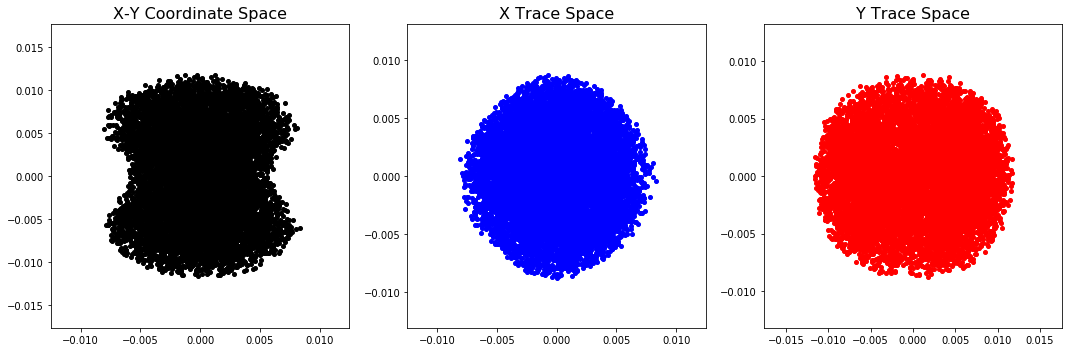

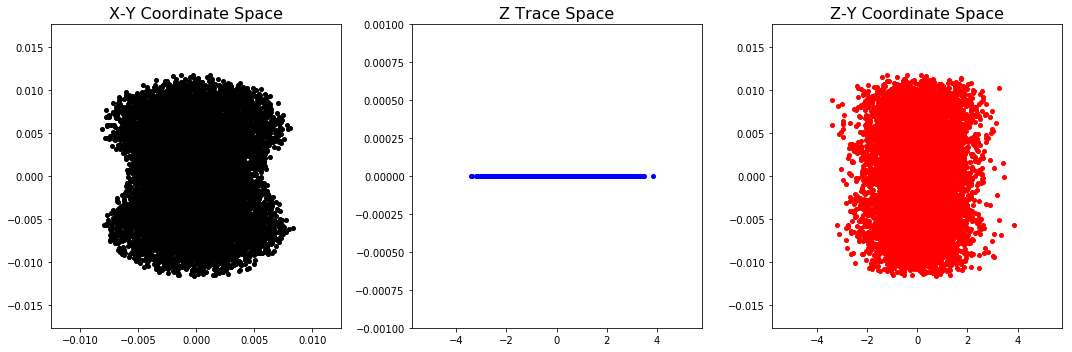

In [16]:
npart = 10000
c0 = 0.01
t0 = 0.4

myNLBunch = bunch.NonlinearBunch(npart, dist = 'waterbag', emitx=20e-6, emity=20e-6, t=t0, c=c0)
myNLBunch.set_longitudinal_coordinates()
myNLBunch.set_transverse_coordinates()
myNLBunch.print_Twiss()

nlKVBunch = read_bunch.read_bunch(myNLBunch.particles, ref, opts.real_particles, comm, l_bucket)
pltbunch.plot_bunch(nlKVBunch)
pltbunch.plot_long(nlKVBunch)

#### Example: Truncated Gaussian

For this bunch we reduce the emittance to limit the tails in the distribution.

Twiss parameters in use:
betax : 1.0
betay : 1.0
alphax : 0.0
alphay : 0.0
gammax : 1.0
gammay : 1.0


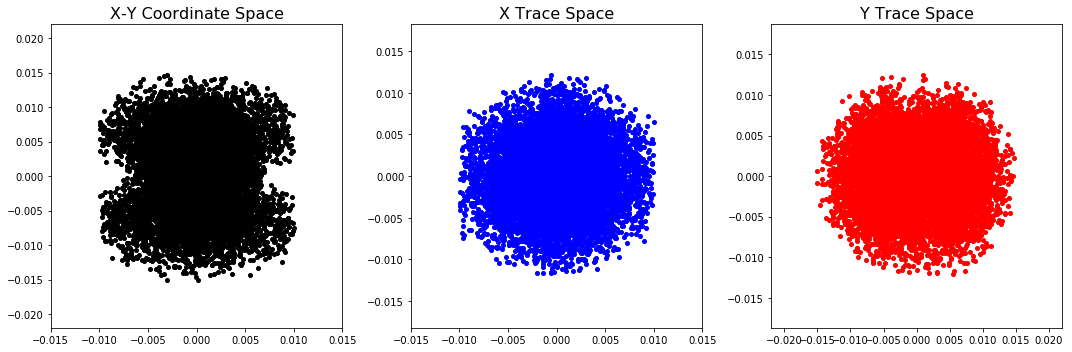

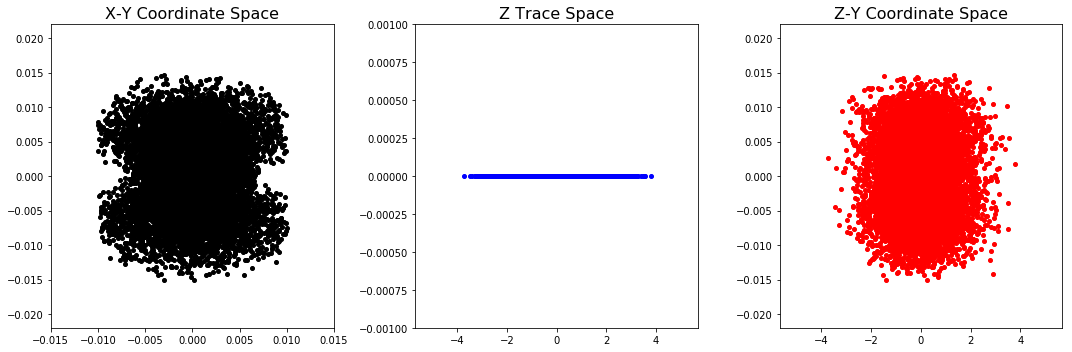

In [25]:
npart = 10000
c0 = 0.01
t0 = 0.4

myNLBunch = bunch.NonlinearBunch(npart, dist = 'Gaussian', emitx=10e-6, emity=10e-6, t=t0, c=c0)
myNLBunch.set_longitudinal_coordinates()
myNLBunch.set_transverse_coordinates()
myNLBunch.print_Twiss()

nlKVBunch = read_bunch.read_bunch(myNLBunch.particles, ref, opts.real_particles, comm, l_bucket)
pltbunch.plot_bunch(nlKVBunch)
pltbunch.plot_long(nlKVBunch)